## Test target densities, samplers, and plotting functions

### Imports

In [1]:

import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import time

import blackjax
import arviz as az

# Bayesian Optimization
from boax.experiments import optimization
from boax.acquisitions.surrogates import single_task_gaussian_process
from boax.acquisitions import upper_confidence_bound

# Import the slightly modified adaptation function
from modified_mams_adaptation import adjusted_mclmc_find_L_and_step_size

# Import target densities
from target_densities import make_bimodal_gaussian_logdensity, make_correlated_gaussian_logdensity, make_banana_logdensity

# Import plot functions
from plot_functions import plot_comparison, plot_trace_and_samples, plot_bayesopt_progress

# Import BayesOpt 
from bayes_opt import objective_function_with_convergence, run_bayesopt_tuning

# Import samplers
from samplers import compute_ess, compute_rhat
from samplers import run_mams_fixed, run_mams_auto, run_multiple_chains_fixed, run_multiple_chains_auto


### Make the banana, correlated Gaussian, and bimodal denisities

In [2]:
dim = 5

target_bimodal = make_bimodal_gaussian_logdensity(mean1 = [-2] * dim, mean2 = [ 2] * dim, correlation = 0)

target_correlated = make_correlated_gaussian_logdensity(dim, correlation=0.5)

target_banana = make_banana_logdensity(dim)


# Test run_mams_fixed
key = jax.random.key(42)
initial_position = jnp.zeros(dim)

### Run MAMS auto tuned on the three targets

Auto tuning chose: L = 4.472 and step size = 0.07148 and inverse mass matrix = [1. 1. 1. 1. 1.]
Number of samples: (10000, 5)
Tuned L: 4.472
Tuned step size: 0.07148
ESS: 13562.9
Acceptance rate: 0.887
Time to run: 19.57s


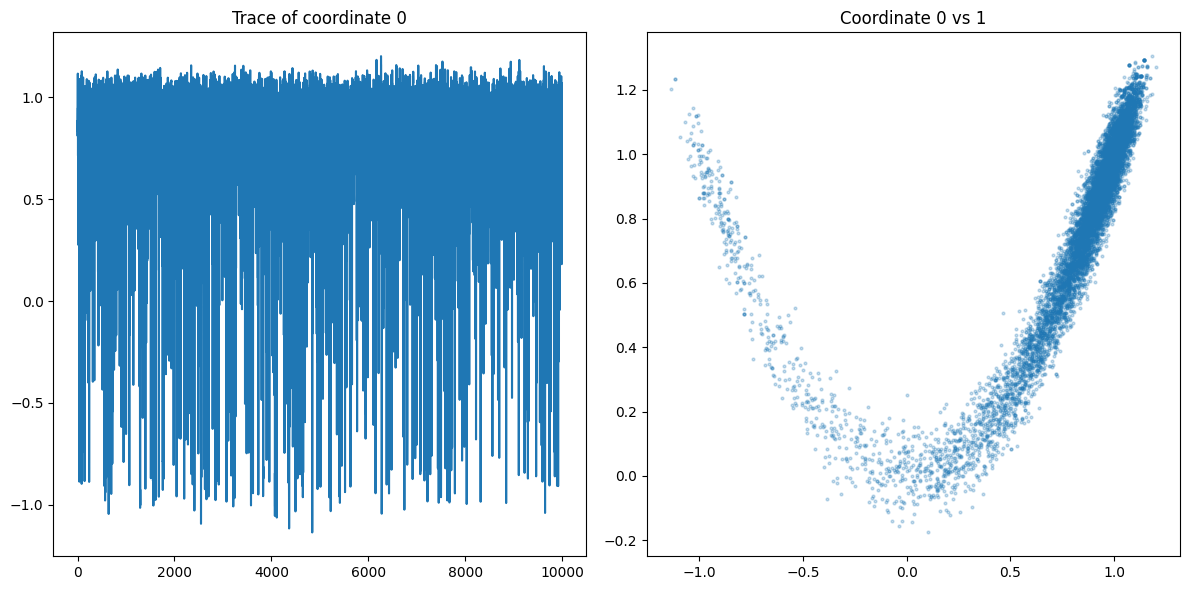

In [3]:

samples, step_size, L, inv_mass_matrix, acc, ess, time = run_mams_auto(logdensity_fn = target_banana, num_steps = 10000, initial_position = initial_position, key = key, tune_mass_matrix = False)

print(f"Number of samples: {samples.shape}")
print(f"Tuned L: {L:.3f}")
print(f"Tuned step size: {step_size:.5f}")
print(f"ESS: {ess:.1f}")
print(f"Acceptance rate: {acc:.3f}")
print(f"Time to run: {time:.2f}s")

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.title('Trace of coordinate 0')
plt.subplot(1, 2, 2)
plt.scatter(samples[:, 0], samples[:, 1], alpha = 0.25, s = 4)
plt.title('Coordinate 0 vs 1')
plt.tight_layout()
plt.show()

### Run MAMS with fixed parameters

  Samples shape: (10000, 5)
  ESS: 21711.9
  Acceptance: 0.923
  Time: 1.80s


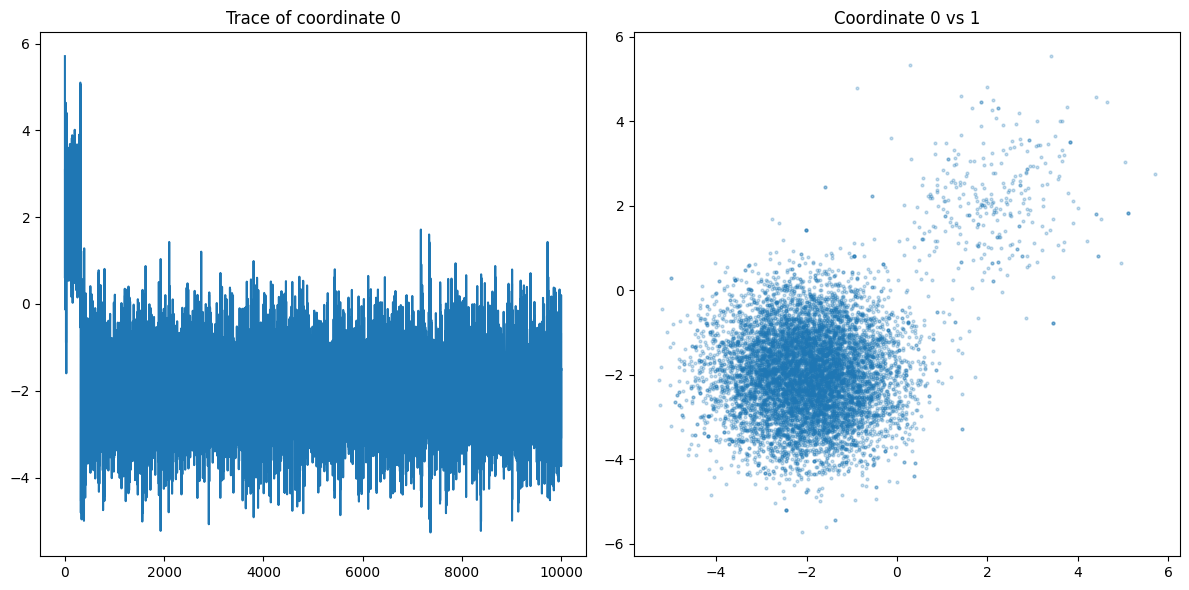

In [4]:
samples, ess, acc, elapsed = run_mams_fixed(logdensity_fn = target_bimodal, chain_length = 10000, initial_position = initial_position, key = key, L = 20, step_size = 3)

print(f"  Samples shape: {samples.shape}")
print(f"  ESS: {ess:.1f}")
print(f"  Acceptance: {acc:.3f}")
print(f"  Time: {elapsed:.2f}s")

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0])
plt.title('Trace of coordinate 0')
plt.subplot(1, 2, 2)
plt.scatter(samples[:, 0], samples[:, 1], alpha = 0.25, s = 4)
plt.title('Coordinate 0 vs 1')
plt.tight_layout()
plt.show()

### Run multiple chains with fixed parameters

---------------- Chain 1 started at [-1.28903721 -1.76963388 -1.52384581  0.11856676 -0.31364914] (first 5 coordinates)
------ ESS = 7145.7, Acceptance rate = 0.999, Time = 1.57s, Samples = 1000
---------------- Chain 2 started at [-0.52601973  0.03776898 -1.70623568 -0.33606137 -0.75197636] (first 5 coordinates)
------ ESS = 7483.1, Acceptance rate = 0.999, Time = 0.90s, Samples = 1000
---------------- Chain 3 started at [ 1.35123605 -0.97188579  0.905156    0.79067888  1.15376866] (first 5 coordinates)
------ ESS = 7740.1, Acceptance rate = 0.999, Time = 1.33s, Samples = 1000
---------------- Chain 4 started at [-1.73504305 -1.74971323  0.89434772  0.9698915   0.77720855] (first 5 coordinates)
------ ESS = 7402.0, Acceptance rate = 0.999, Time = 1.23s, Samples = 1000
---------------- Chain 5 started at [ 0.55100686 -0.71092565  1.50955211 -0.50785618  0.36323787] (first 5 coordinates)
------ ESS = 7044.7, Acceptance rate = 0.999, Time = 1.21s, Samples = 1000
Samples: (5, 1000, 5) (nu

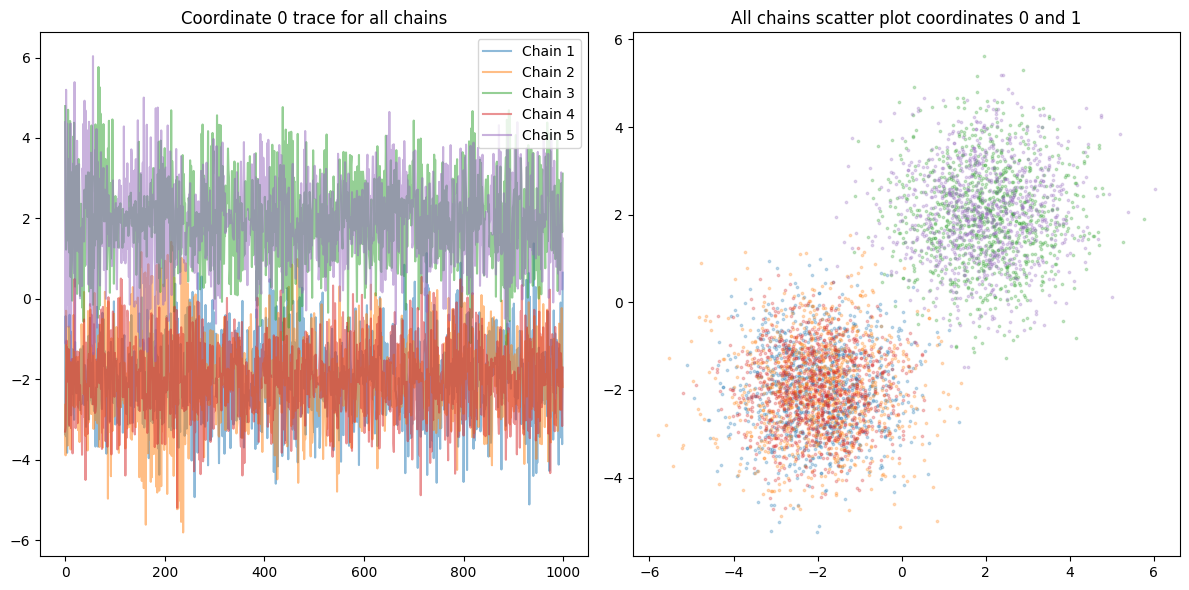

In [5]:
samples, ess_array, acc_array, time_array, start_positions = run_multiple_chains_fixed(logdensity_fn = target_bimodal, num_chains = 5, num_steps = 1000, initial_position = initial_position, base_key = key, L = 10, step_size = 1)
rhat = compute_rhat(samples)

print(f"Samples: {samples.shape} (number of chains, chain length, dim)")
print(f"Mean ESS: {jnp.mean(ess_array):.1f} +/- std {jnp.std(ess_array):.1f}")
print(f"Max  R-hat: {rhat:.4f}")
print(f"Mean acceptance rate: {jnp.mean(acc_array):.3f} +/- std deviation {jnp.std(acc_array):.3f}")
print(f"Mean time: {jnp.mean(time_array):.2f}s")

# Plot traces
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(samples.shape[0]): # Number of chains
    plt.plot(samples[i, :, 0], alpha = 0.5, label=f'Chain {i+1}')
plt.title('Coordinate 0 trace for all chains')
plt.legend()


# Plot scatter plot
plt.subplot(1, 2, 2)
for i in range(samples.shape[0]):
    plt.scatter(samples[i, :, 0], samples[i, :, 1], alpha = 0.25, s = 3)
plt.title('All chains scatter plot coordinates 0 and 1')
plt.tight_layout()
plt.show()

### Run multiple chains auto-tuned

---------------- Chain 1 started at [-1.28903721 -1.76963388 -1.52384581  0.11856676 -0.31364914] (first 5 coordinates)
Auto tuning chose: L = 2.154 and step size = 1.95812 and inverse mass matrix = [1. 1. 1. 1. 1.]
------ L = 2.15, step size = 1.95812  ESS = 1568.3, Acceptance rate = 0.969, Time = 6.33s, Samples = 1000
---------------- Chain 2 started at [-0.52601973  0.03776898 -1.70623568 -0.33606137 -0.75197636] (first 5 coordinates)
Auto tuning chose: L = 1.612 and step size = 1.46552 and inverse mass matrix = [1. 1. 1. 1. 1.]
------ L = 1.61, step size = 1.46552  ESS = 1729.2, Acceptance rate = 0.987, Time = 3.02s, Samples = 1000
---------------- Chain 3 started at [ 1.35123605 -0.97188579  0.905156    0.79067888  1.15376866] (first 5 coordinates)
Auto tuning chose: L = 3.918 and step size = 2.50197 and inverse mass matrix = [1. 1. 1. 1. 1.]
------ L = 3.92, step size = 2.50197  ESS = 1704.3, Acceptance rate = 0.917, Time = 3.99s, Samples = 1000
---------------- Chain 4 started a

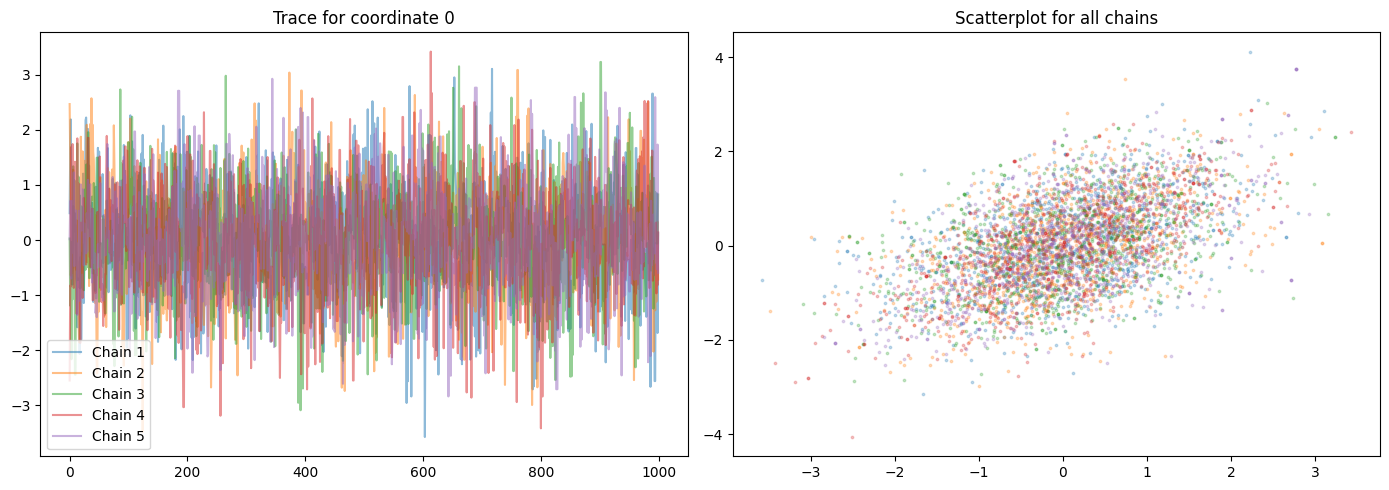

In [6]:
samples, ess_arr, acc_arr, step_vals, L_vals, time_arr, starts, inv_mass_matrices = (run_multiple_chains_auto(logdensity_fn = target_correlated, num_chains = 5, num_steps = 1000, initial_position = initial_position, base_key = key, perturb_base_key = key, tune_mass_matrix = False))
rhat = compute_rhat(samples)

print(f"Samples dimensions: {samples.shape}")
print(f"mean ESS: {jnp.mean(ess_arr):.3f} +/- std {jnp.std(ess_arr):.3f}")
print(f"Max R-hat: {rhat:.5f}")
print(f"Mean acceptance rate: {jnp.mean(acc_arr):.3f} +/- std deviation {jnp.std(acc_arr):.3f}")
print(f"L mean: {jnp.mean(L_vals):.3f} +/- std {jnp.std(L_vals):.3f}")
print(f"Mean step size: {jnp.mean(step_vals):.4f} +- stadard deviation {jnp.std(step_vals):.4f}")
print(f"Mean time per chain: {jnp.mean(time_arr):.2f}s +/- {jnp.std(time_arr):.2f}")

# Plot all chains
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
for i in range(samples.shape[0]): # Over all chains
    plt.plot(samples[i, :, 0], alpha = 0.5, label=f'Chain {i+1}') # Trace for that chain for coordinate 0
plt.title('Trace for coordinate 0')
plt.legend()

# Scatterplot
plt.subplot(1, 2, 2)
for i in range(samples.shape[0]):
    plt.scatter(samples[i, :, 0], samples[i, :, 1], alpha = 0.25, s = 3)
plt.title('Scatterplot for all chains')
plt.tight_layout()
plt.show()

### Bayes opt

######################################### Iteration 1/10
Running 4 chains with L = 39.588, and step size = 1.3553
---------------- Chain 1 started at [ 1.4350817  -2.1573902  -0.14436824 -0.97810238  0.3567619 ] (first 5 coordinates)
------ ESS = 7767.2, Acceptance rate = 0.995, Time = 0.90s, Samples = 1000
---------------- Chain 2 started at [-0.93746422 -0.42442718 -0.48630877  0.20787363  0.18122714] (first 5 coordinates)
------ ESS = 1214.2, Acceptance rate = 0.995, Time = 0.92s, Samples = 1000
---------------- Chain 3 started at [-0.31495524 -1.85903798 -0.40495538 -1.20226673  0.43237154] (first 5 coordinates)
------ ESS = 1029.6, Acceptance rate = 0.995, Time = 0.74s, Samples = 1000
---------------- Chain 4 started at [ 0.78309278  1.07116437 -1.28227674 -0.54975842 -1.02978529] (first 5 coordinates)
------ ESS = 1468.7, Acceptance rate = 0.995, Time = 0.99s, Samples = 1000
ESS = 2869.9, R-hat = 1.433, Acceptance rate = 0.995, Objective function = 1136.1
########################

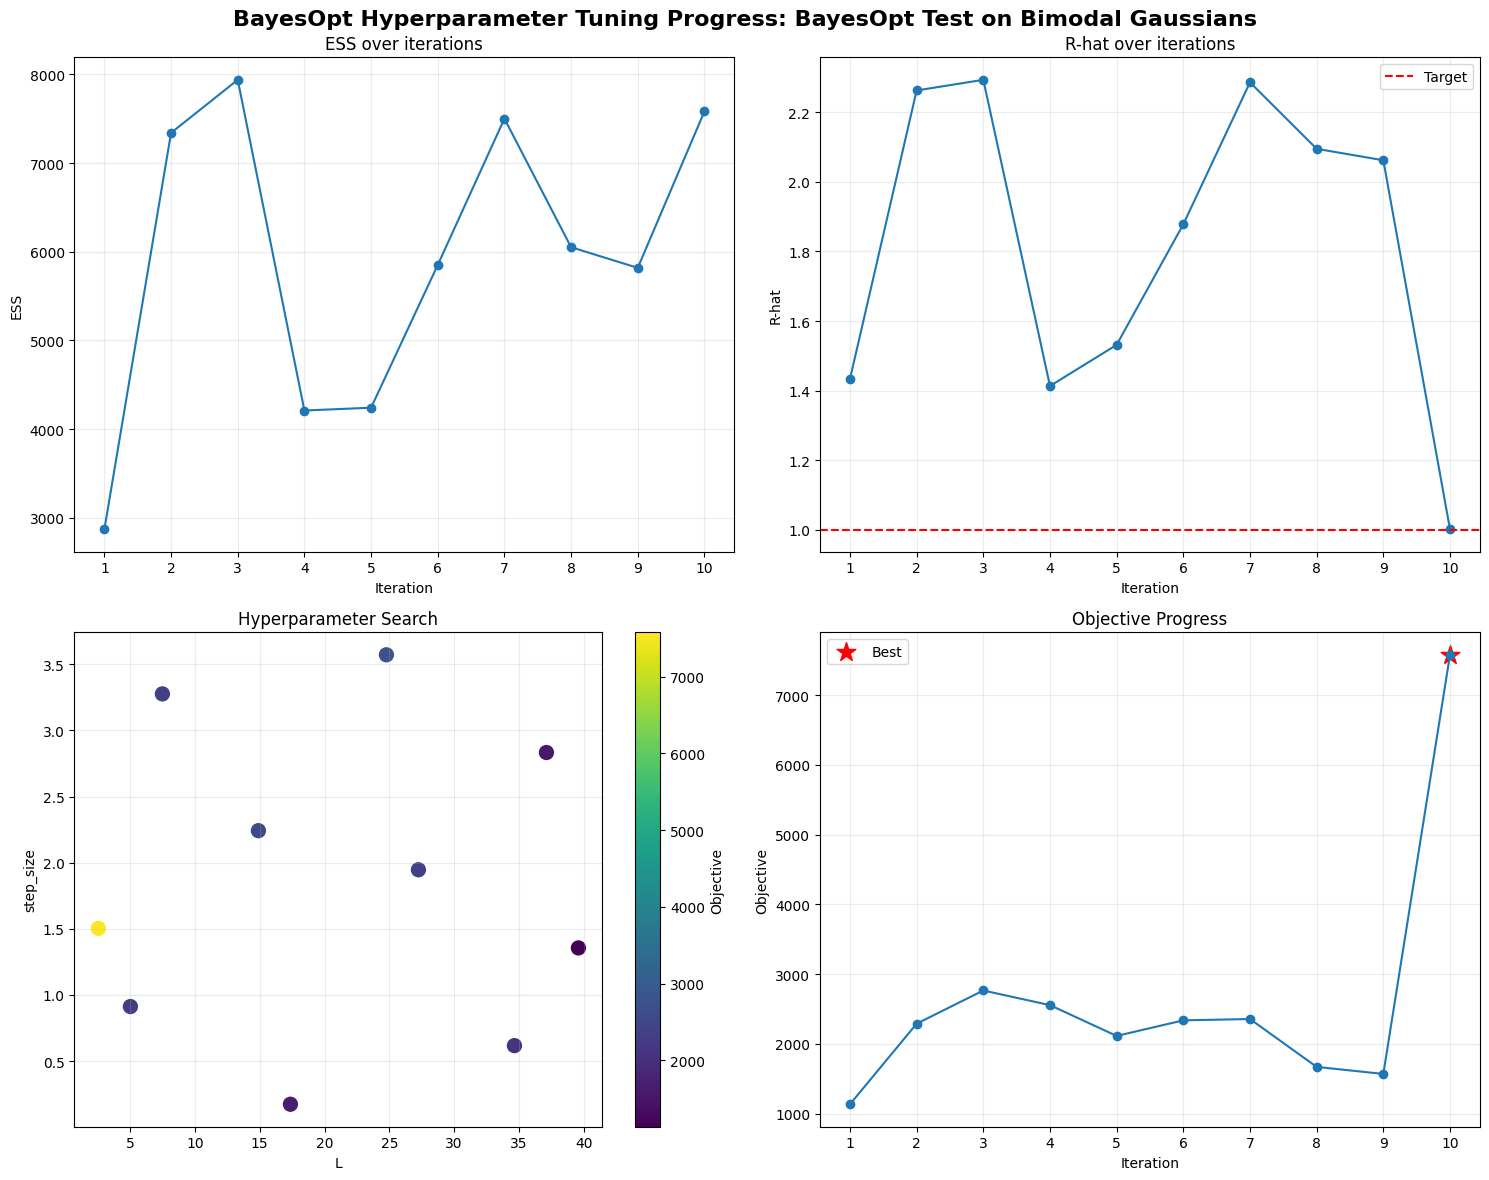

In [7]:
bayes_results, best_params = run_bayesopt_tuning(logdensity_fn = target_bimodal, initial_position = initial_position, tuning_key = key, num_iterations = 10, tuning_chains = 4, chain_length = 1000)

print(f"Best trajectory length L: {best_params['L']:.3f}")
print(f"Best step size: {best_params['step_size']:.4f}")

plot_bayesopt_progress(bayes_results, "BayesOpt Test on Bimodal Gaussians", save_path = "bayesopt_test_bimodal.png")
plt.show()